In [36]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
from tqdm.notebook import tqdm
import re
import datetime
import time
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [20]:
class DataProcessor:
    """    
    Attributes:
    ----------
    data : pd.DataFrame
        rawデータ
    data_p : pd.DataFrame
        preprocessing後のデータ
    data_h : pd.DataFrame
        merge_horse_results後のデータ
    data_pe : pd.DataFrame
        merge_peds後のデータ
    data_c : pd.DataFrame
        process_categorical後のデータ
    no_peds: Numpy.array
        merge_pedsを実行した時に、血統データが存在しなかった馬のhorse_id一覧
    """
    
    def __init__(self):
        self.data = pd.DataFrame()
        self.data_p = pd.DataFrame()
        self.data_h = pd.DataFrame()
        self.data_pe = pd.DataFrame()
        self.data_c = pd.DataFrame()
        
    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        """
        馬の過去成績データから、
        n_samples_listで指定されたレース分の着順と賞金の平均を追加してdata_hに返す

        Parameters:
        ----------
        hr : HorseResults
            馬の過去成績データ
        n_samples_list : list, default [5, 9, 'all']
            過去何レース分追加するか
        """

        self.data_h = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_h = hr.merge_all(self.data_h, n_samples=n_samples)
            
        #6/6追加： 馬の出走間隔追加
        self.data_h['interval'] = (self.data_h['date'] - self.data_h['latest']).dt.days
        self.data_h.drop(['開催', 'latest'], axis=1, inplace=True)
        
    def merge_peds(self, peds):
        """
        5世代分血統データを追加してdata_peに返す

        Parameters:
        ----------
        peds : Peds.peds_e
            Pedsクラスで加工された血統データ。
        """

        self.data_pe = \
            self.data_h.merge(peds, left_on='horse_id', right_index=True,
                                                             how='left')
        self.no_peds = self.data_pe[self.data_pe['peds_0'].isnull()]\
            ['horse_id'].unique()
        if len(self.no_peds) > 0:
            print('scrape peds at horse_id_list "no_peds"')
            
    def process_categorical(self, le_horse, le_jockey, results_m):
        """
        カテゴリ変数を処理してdata_cに返す

        Parameters:
        ----------
        le_horse : sklearn.preprocessing.LabelEncoder
            horse_idを0始まりの整数に変換するLabelEncoderオブジェクト。
        le_jockey : sklearn.preprocessing.LabelEncoder
            jockey_idを0始まりの整数に変換するLabelEncoderオブジェクト。
        results_m : Results.data_pe
            ダミー変数化のとき、ResultsクラスとShutubaTableクラスで列を合わせるためのもの
        """

        df = self.data_pe.copy()
        
        #ラベルエンコーディング。horse_id, jockey_idを0始まりの整数に変換
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        #horse_id, jockey_idをpandasのcategory型に変換
        df['horse_id'] = df['horse_id'].astype('category')
        df['jockey_id'] = df['jockey_id'].astype('category')
        
        #そのほかのカテゴリ変数をpandasのcategory型に変換してからダミー変数化
        #列を一定にするため
        weathers = results_m['weather'].unique()
        race_types = results_m['race_type'].unique()
        ground_states = results_m['ground_state'].unique()
        sexes = results_m['性'].unique()
        df['weather'] = pd.Categorical(df['weather'], weathers)
        df['race_type'] = pd.Categorical(df['race_type'], race_types)
        df['ground_state'] = pd.Categorical(df['ground_state'], ground_states)
        df['性'] = pd.Categorical(df['性'], sexes)
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])
        
        self.data_c = df

In [125]:
class Results(DataProcessor):
    def __init__(self, results):
        super(Results, self).__init__()
        self.data = results
        
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(race_id_list):
        """
        レース結果データをスクレイピングする関数

        Parameters:
        ----------
        race_id_list : list
            レースIDのリスト

        Returns:
        ----------
        race_results_df : pandas.DataFrame
            全レース結果データをまとめてDataFrame型にしたもの
        """

        #race_idをkeyにしてDataFrame型を格納
        race_results = {}
        for race_id in tqdm(race_id_list):
            time.sleep(1)
            try:
                url = "https://db.netkeiba.com/race/" + race_id

                html = requests.get(url)
                html.encoding = "EUC-JP"

                #メインとなるテーブルデータを取得
                df = pd.read_html(html.text)[0]
                # 列名に半角スペースがあれば除去する
                df = df.rename(columns=lambda x: x.replace(' ', ''))

                # 天候、レースの種類、コースの長さ、馬場の状態、日付をスクレイピング
                soup = BeautifulSoup(html.text, "html.parser")
                texts = (
                    soup.find("div", attrs={"class": "data_intro"}).find_all("p")[0].text
                    + soup.find("div", attrs={"class": "data_intro"}).find_all("p")[1].text
                )
                info = re.findall(r'\w+', texts)
                for text in info:
                    if text in ["芝", "ダート"]:
                        df["race_type"] = [text] * len(df)
                    if "障" in text:
                        df["race_type"] = ["障害"] * len(df)
                    if "m" in text:
                        df["course_len"] = [int(re.findall(r"\d+", text)[-1])] * len(df) #20211212：[0]→[-1]に修正
                    if text in ["良", "稍重", "重", "不良"]:
                        df["ground_state"] = [text] * len(df)
                    if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                        df["weather"] = [text] * len(df)
                    if "年" in text:
                        df["date"] = [text] * len(df)

                #馬ID、騎手IDをスクレイピング
                horse_id_list = []
                horse_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                    "a", attrs={"href": re.compile("^/horse")}
                )
                for a in horse_a_list:
                    horse_id = re.findall(r"\d+", a["href"])
                    horse_id_list.append(horse_id[0])
                jockey_id_list = []
                jockey_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                    "a", attrs={"href": re.compile("^/jockey")}
                )
                for a in jockey_a_list:
                    jockey_id = re.findall(r"\d+", a["href"])
                    jockey_id_list.append(jockey_id[0])
                df["horse_id"] = horse_id_list
                df["jockey_id"] = jockey_id_list

                #インデックスをrace_idにする
                df.index = [race_id] * len(df)

                race_results[race_id] = df
            #存在しないrace_idを飛ばす
            except IndexError:
                continue
            except AttributeError: #存在しないrace_idでAttributeErrorになるページもあるので追加
                continue
            #wifiの接続が切れた時などでも途中までのデータを返せるようにする
            except Exception as e:
                print(e)
                break
            #Jupyterで停止ボタンを押した時の対処
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる
        race_results_df = pd.concat([race_results[key] for key in race_results])

        return race_results_df
    
    #前処理    
    def preprocessing(self):
        df = self.data.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        df['rank'] = df["着順"].map(lambda x: x if x < 4 else 4)

        # 性齢を性と年齢に分ける
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df["体重"] = df["馬体重"].str.split("(", expand=True)[0]
        df["体重変化"] = df["馬体重"].str.split("(", expand=True)[1].str[:-1]
        
        #errors='coerce'で、"計不"など変換できない時に欠損値にする
        df['体重'] = pd.to_numeric(df['体重'], errors='coerce')
        df['体重変化'] = pd.to_numeric(df['体重変化'], errors='coerce')

        # 単勝をfloatに変換
        df["単勝"] = df["単勝"].astype(float)
        # 距離は10の位を切り捨てる
        df["course_len"] = df["course_len"].astype(float) // 100

        # 不要な列を削除
        df.drop(["タイム", "着差", "調教師", "性齢", "馬体重", '馬名', '騎手'],
                axis=1, inplace=True)

        df["date"] = pd.to_datetime(df["date"], format="%Y年%m月%d日")
        
        #開催場所
        df['開催'] = df.index.map(lambda x:str(x)[4:6])
        
        #6/6出走数追加
        df['n_horses'] = df.index.map(df.index.value_counts())

        self.data_p = df
    
    #カテゴリ変数の処理
    def process_categorical(self):
        self.le_horse = LabelEncoder().fit(self.data_pe['horse_id'])
        self.le_jockey = LabelEncoder().fit(self.data_pe['jockey_id'])
        super().process_categorical(self.le_horse, self.le_jockey, self.data_pe)

In [10]:
# #レースIDのリストを作る
race_id_list = []
for place in range(1, 11, 1):
    for kai in range(1, 6, 1):
        for day in range(1, 13, 1):
            for r in range(1, 13, 1):
                race_id = "2022" + str(place).zfill(2) + str(kai).zfill(2) +\
                str(day).zfill(2) + str(r).zfill(2)
                race_id_list.append(race_id)

results = Results.scrape(race_id_list)
results.to_pickle('results2.pickle')

  0%|          | 0/7200 [00:00<?, ?it/s]

In [ ]:
# def scrape_race_results(race_id_list, pre_race_results={}):
#     race_results = pre_race_results.copy()
#     for race_id in tqdm(race_id_list):
#         if race_id in race_results.keys():
#             continue
#         time.sleep(1)
#         try:
#             url = "https://db.netkeiba.com/race/" + race_id
#             race_results[race_id] = pd.read_html(url)[0]
#         except IndexError:
#             continue
#         except AttributeError:
#             continue
#         except Exception as e:
#             print(e)
#             break
#         except:
#             break
#     return race_results

# #レースIDのリストを作る
# race_id_list = []
# for place in range(1, 11, 1):
#     for kai in range(1, 6, 1):
#         for day in range(1, 13, 1):
#             for r in range(1, 13, 1):
#                 race_id = "2022" + str(place).zfill(2) + str(kai).zfill(2) +\
#                 str(day).zfill(2) + str(r).zfill(2)
#                 race_id_list.append(race_id)

# #スクレイピングしてデータを保存
# test3 = scrape_race_results(race_id_list)
# for key in test3:
#     test3[key].index = [key] * len(test3[key])
# results = pd.concat([test3[key] for key in test3], sort=False) 
# results.to_pickle('results.pickle')

In [31]:
class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付', '着順', '賞金', '着差', '通過', '開催', '距離']]
        self.preprocessing()
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        """
        馬の過去成績データをスクレイピングする関数

        Parameters:
        ----------
        horse_id_list : list
            馬IDのリスト

        Returns:
        ----------
        horse_results_df : pandas.DataFrame
            全馬の過去成績データをまとめてDataFrame型にしたもの
        """

        #horse_idをkeyにしてDataFrame型を格納
        horse_results = {}
        for horse_id in tqdm(horse_id_list):
            time.sleep(1)
            try:
                url = 'https://db.netkeiba.com/horse/' + horse_id
                df = pd.read_html(url)[3]
                #受賞歴がある馬の場合、3番目に受賞歴テーブルが来るため、4番目のデータを取得する
                if df.columns[0]=='受賞歴':
                    df = pd.read_html(url)[4]
                df.index = [horse_id] * len(df)
                horse_results[horse_id] = df
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる        
        horse_results_df = pd.concat([horse_results[key] for key in horse_results])

        return horse_results_df
    
    def preprocessing(self):
        df = self.horse_results.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)

        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)
        
        #賞金のNaNを0で埋める
        df['賞金'].fillna(0, inplace=True)
        
        #1着の着差を0にする
        df['着差'] = df['着差'].map(lambda x: 0 if x<0 else x)
        
        #レース展開データ
        #n=1: 最初のコーナー位置, n=4: 最終コーナー位置
        def corner(x, n):
            if type(x) != str:
                return x
            elif n==4:
                return int(re.findall(r'\d+', x)[-1])
            elif n==1:
                return int(re.findall(r'\d+', x)[0])
        df['first_corner'] = df['通過'].map(lambda x: corner(x, 1))
        df['final_corner'] = df['通過'].map(lambda x: corner(x, 4))
        
        df['final_to_rank'] = df['final_corner'] - df['着順']
        df['first_to_rank'] = df['first_corner'] - df['着順']
        df['first_to_final'] = df['first_corner'] - df['final_corner']
        
        #開催場所
        df['開催'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        #race_type
        df['race_type'] = df['距離'].str.extract(r'(\D+)')[0].map(race_type_dict)
        #距離は10の位を切り捨てる
        #一部の馬で欠損値があり、intに変換できないためfloatに変換する
        df['course_len'] = df['距離'].str.extract(r'(\d+)').astype(float) // 100
        df.drop(['距離'], axis=1, inplace=True)
        #インデックス名を与える
        df.index.name = 'horse_id'
        
        self.horse_results = df
        self.target_list = ['着順', '賞金', '着差', 'first_corner', 'final_corner',
                            'first_to_rank', 'first_to_final','final_to_rank']
    
    #n_samplesレース分馬ごとに平均する
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.query('index in @horse_id_list')
        
        #過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].\
                sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
        
        #集計して辞書型に入れる
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list].mean()\
            .add_suffix('_{}R'.format(n_samples))
        for column in ['course_len', 'race_type', '開催']:
            self.average_dict[column] = filtered_df.groupby(['horse_id', column])\
                [self.target_list].mean().add_suffix('_{}_{}R'.format(column, n_samples))

        #6/6追加: 馬の出走間隔追加のために、全レースの日付を変数latestに格納
        if n_samples == 5:
            self.latest = filtered_df.groupby('horse_id')['date'].max().rename('latest')
    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        horse_id_list = df['horse_id']
        self.average(horse_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='horse_id',
                             right_index=True, how='left')
        for column in ['course_len','race_type', '開催']:
            merged_df = merged_df.merge(self.average_dict[column], 
                                        left_on=['horse_id', column],
                                        right_index=True, how='left')

        #6/6追加：馬の出走間隔追加のために、全レースの日付を変数latestに格納
        if n_samples == 5:
            merged_df = merged_df.merge(self.latest, left_on='horse_id',
                             right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
        return merged_df

#開催場所をidに変換するための辞書型
place_dict = {
    '札幌':'01',  '函館':'02',  '福島':'03',  '新潟':'04',  '東京':'05', 
    '中山':'06',  '中京':'07',  '京都':'08',  '阪神':'09',  '小倉':'10'
}

#レースタイプをレース結果データと整合させるための辞書型
race_type_dict = {
    '芝': '芝', 'ダ': 'ダート', '障': '障害'
}

In [56]:
#上で保存したpickleファイルの読み込み
results = pd.read_pickle('results2.pickle')

horse_id_list = results['horse_id'].unique()
horse_results = HorseResults.scrape(horse_id_list)
horse_results #jupyterで出力

horse_results.to_pickle('horse_results.pickle')

  0%|          | 0/11260 [00:00<?, ?it/s]

In [21]:
class Peds:
    def __init__(self, peds):
        self.peds = peds
        self.peds_e = pd.DataFrame() #after label encoding and transforming into category
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        """
        血統データをスクレイピングする関数

        Parameters:
        ----------
        horse_id_list : list
            馬IDのリスト

        Returns:
        ----------
        peds_df : pandas.DataFrame
            全血統データをまとめてDataFrame型にしたもの
        """

        peds_dict = {}
        for horse_id in tqdm(horse_id_list):
            time.sleep(1)
            try:
                url = "https://db.netkeiba.com/horse/ped/" + horse_id
                df = pd.read_html(url)[0]

                #重複を削除して1列のSeries型データに直す
                generations = {}
                for i in reversed(range(5)):
                    generations[i] = df[i]
                    df.drop([i], axis=1, inplace=True)
                    df = df.drop_duplicates()
                ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)

                peds_dict[horse_id] = ped.reset_index(drop=True)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #列名をpeds_0, ..., peds_61にする
        peds_df = pd.concat([peds_dict[key] for key in peds_dict], axis=1).T.add_prefix('peds_')

        return peds_df
    
    def encode(self):
        df = self.peds.copy()
        for column in df.columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
        self.peds_e = df.astype('category')

In [19]:
#上で保存したpickleファイルの読み込み
results = pd.read_pickle('results2.pickle')

horse_id_list = results['horse_id'].unique()
peds_results = Peds.scrape(horse_id_list)
peds_results #jupyterで出力

peds_results.to_pickle('peds_results.pickle')

  0%|          | 0/11260 [00:00<?, ?it/s]

In [32]:
hr = HorseResults.read_pickle(['horse_results.pickle'])
hr.horse_results #jupyterで出力

,着順,賞金,着差,通過,開催,date,first_corner,final_corner,final_to_rank,first_to_rank,first_to_final,race_type,course_len
horse_id,,,,,,,,,,,,,
2020100678,7,0.0,0.6,14-14,09,2023-09-16,14.0,14.0,7.0,7.0,0.0,芝,16.0
2020100678,8,0.0,0.8,6-5-5,01,2023-08-19,6.0,5.0,-3.0,-2.0,1.0,芝,15.0
2020100678,5,80.0,0.8,5-5-5-4,01,2023-07-23,5.0,4.0,-1.0,0.0,1.0,芝,20.0
2020100678,2,437.6,0.1,1-1-1-1,08,2023-05-13,1.0,1.0,-1.0,-1.0,0.0,芝,20.0
2020100678,3,272.6,0.6,5-4,08,2023-04-22,5.0,4.0,1.0,2.0,1.0,芝,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015103344,4,150.0,0.8,2-2-3-2,08,2018-04-21,2.0,2.0,-2.0,-2.0,0.0,芝,24.0
2015103344,1,500.0,0.0,2-2-2-2,09,2018-03-25,2.0,2.0,1.0,1.0,0.0,芝,24.0
2015103344,3,130.0,0.5,9-9-9-7,10,2018-03-03,9.0,7.0,4.0,6.0,2.0,芝,20.0


In [25]:
p = Peds.read_pickle(['peds_results.pickle'])
p.encode()
p.peds_e #jupyterで出力

,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
2020100678,395,2623,159,382,685,2913,92,194,177,397,...,49,258,186,367,493,878,165,137,554,631
2020102526,323,5541,172,339,455,1241,95,164,15,289,...,320,597,110,98,348,650,342,434,1204,428
2020102535,429,7144,172,394,125,989,95,164,54,197,...,301,447,108,351,407,404,82,790,1101,1652
2020105743,173,1089,176,332,762,3729,95,187,125,258,...,302,25,123,119,439,279,325,250,1218,2859
2020102360,401,6308,141,363,588,2028,45,189,198,322,...,234,178,110,98,348,650,86,714,445,274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019103821,347,586,21,141,568,1793,101,52,10,114,...,33,602,61,32,159,304,253,1122,1299,3060
2019100398,285,6589,146,239,603,4710,103,72,11,146,...,209,157,118,318,457,854,224,593,1321,2810
2019105085,209,964,59,378,685,1655,55,82,228,199,...,49,258,176,200,179,421,295,478,1114,1638
2020103369,395,2206,159,382,636,1863,92,194,177,397,...,422,703,96,95,107,855,135,1060,194,522


In [126]:
r = Results.read_pickle(['results2.pickle'])
r.preprocessing()
r.data_p.head() #jupyterで出力

,着順,枠番,馬番,斤量,単勝,人気,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,rank,性,年齢,体重,体重変化,開催,n_horses
202201010101,1,1,1,54.0,1.2,1.0,18.0,曇,芝,稍重,2022-07-23,2020100678,00666,1,牡,2,436,0,01,5
202201010101,2,3,3,54.0,11.3,3.0,18.0,曇,芝,稍重,2022-07-23,2020102526,01170,1,牡,2,450,-6,01,5
202201010101,3,5,5,54.0,4.3,2.0,18.0,曇,芝,稍重,2022-07-23,2020102535,01140,1,牡,2,412,-6,01,5
202201010101,4,2,2,54.0,17.2,4.0,18.0,曇,芝,稍重,2022-07-23,2020105743,01091,4,牡,2,432,-2,01,5
202201010101,5,4,4,54.0,28.4,5.0,18.0,曇,芝,稍重,2022-07-23,2020102360,01144,4,牡,2,460,6,01,5


In [127]:
r.merge_horse_results(hr, n_samples_list=[5, 9, 'all'])
r.data_h.head() #jupyterで出力

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

,着順,枠番,馬番,斤量,単勝,人気,course_len,weather,race_type,ground_state,...,final_to_rank_race_type_allR,着順_開催_allR,賞金_開催_allR,着差_開催_allR,first_corner_開催_allR,final_corner_開催_allR,first_to_rank_開催_allR,first_to_final_開催_allR,final_to_rank_開催_allR,interval
202201010101,1,1,1,54.0,1.2,1.0,18.0,曇,芝,稍重,...,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0
202201010101,2,3,3,54.0,11.3,3.0,18.0,曇,芝,稍重,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
202201010101,3,5,5,54.0,4.3,2.0,18.0,曇,芝,稍重,...,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0
202201010101,4,2,2,54.0,17.2,4.0,18.0,曇,芝,稍重,...,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0
202201010101,5,4,4,54.0,28.4,5.0,18.0,曇,芝,稍重,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0


In [128]:
r.merge_peds(p.peds_e)
r.data_pe.head() #jupyterで出力

,着順,枠番,馬番,斤量,単勝,人気,course_len,weather,race_type,ground_state,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
202201010101,1,1,1,54.0,1.2,1.0,18.0,曇,芝,稍重,...,49,258,186,367,493,878,165,137,554,631
202201010101,2,3,3,54.0,11.3,3.0,18.0,曇,芝,稍重,...,320,597,110,98,348,650,342,434,1204,428
202201010101,3,5,5,54.0,4.3,2.0,18.0,曇,芝,稍重,...,301,447,108,351,407,404,82,790,1101,1652
202201010101,4,2,2,54.0,17.2,4.0,18.0,曇,芝,稍重,...,302,25,123,119,439,279,325,250,1218,2859
202201010101,5,4,4,54.0,28.4,5.0,18.0,曇,芝,稍重,...,234,178,110,98,348,650,86,714,445,274


In [129]:
r.process_categorical() #r.le_horse, r.le_jockeyに対応関係が保存される

In [130]:
r.data_c.to_pickle('data_c.pickle')

In [131]:
r.data_c.head() #jupyterで出力

,着順,枠番,馬番,斤量,単勝,人気,course_len,date,horse_id,jockey_id,...,race_type_芝,race_type_ダート,race_type_障害,ground_state_稍重,ground_state_重,ground_state_良,ground_state_不良,性_牡,性_セ,性_牝
202201010101,1,1,1,54.0,1.2,1.0,18.0,2022-07-23,8435,4,...,1,0,0,1,0,0,0,1,0,0
202201010101,2,3,3,54.0,11.3,3.0,18.0,2022-07-23,9104,108,...,1,0,0,1,0,0,0,1,0,0
202201010101,3,5,5,54.0,4.3,2.0,18.0,2022-07-23,9108,82,...,1,0,0,1,0,0,0,1,0,0
202201010101,4,2,2,54.0,17.2,4.0,18.0,2022-07-23,10509,47,...,1,0,0,1,0,0,0,1,0,0
202201010101,5,4,4,54.0,28.4,5.0,18.0,2022-07-23,9054,86,...,1,0,0,1,0,0,0,1,0,0


In [ ]:
import requests
from bs4 import BeautifulSoup
import time
from tqdm.notebook import tqdm
import re
import datetime

def scrape_race_info(race_id_list):
    race_infos = {}
    for race_id in tqdm(race_id_list):
        time.sleep(1)
        try:
            url = "https://db.netkeiba.com/race/" + race_id
            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup = BeautifulSoup(html.text, "html.parser")

            texts = (
                soup.find("div", attrs={"class": "data_intro"}).find_all("p")[0].text
                + soup.find("div", attrs={"class": "data_intro"}).find_all("p")[1].text
            )
            info = re.findall(r"\w+", texts)
            info_dict = {}
            for text in info:
                if text in ["芝", "ダート"]:
                    info_dict["race_type"] = text
                if "障" in text:
                    info_dict["race_type"] = "障害"
                if "m" in text:
                    info_dict["course_len"] = int(re.findall(r"\d+", text)[0])
                if text in ["良", "稍重", "重", "不良"]:
                    info_dict["ground_state"] = text
                if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                    info_dict["weather"] = text
                if "年" in text:
                    info_dict["date"] = text
            race_infos[race_id] = info_dict
        except IndexError:
            continue
        except AttributeError: #存在しないrace_idでAttributeErrorになるページもあるので追加
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    return race_infos

#前回保存したpickleファイルからデータ取得
results = pd.read_pickle('results.pickle')

#レースID一覧を取得してスクレイピング
race_id_list = results.index.unique()
race_infos = scrape_race_info(race_id_list)

#DataFrame型にする
race_infos = pd.DataFrame(race_infos).T

#resultsに結合
results_addinfo = results.merge(race_infos, left_index=True, right_index=True, how="inner")

In [ ]:
from urllib.request import urlopen

def scrape_return_tables(race_id_list):
    return_tables = {}
    for race_id in tqdm(race_id_list):
        time.sleep(1)
        try:
            url = "https://db.netkeiba.com/race/" + race_id
            
            #普通にスクレイピングすると複勝やワイドなどが区切られないで繋がってしまう。
            #そのため、改行コードを文字列brに変換して後でsplitする
            f = urlopen(url)
            html = f.read()
            html = html.replace(b'<br />', b'br')
            dfs = pd.read_html(html)

            #dfsの1番目に単勝〜馬連、2番目にワイド〜三連単がある
            df = pd.concat([dfs[1], dfs[2]])

            df.index = [race_id] * len(df)
            return_tables[race_id] = df
        except IndexError:
            continue
        except AttributeError:
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    return return_tables

results = pd.read_pickle('results.pickle')

#レースID一覧を取得してスクレイピング
race_id_list = results.index.unique()
race_return = scrape_return_tables(race_id_list)

race_return.to_pickle('race_return.pickle')

print(race_return)

In [82]:
return_tables = race_return

for key in return_tables.keys():
    return_tables[key].index = [key]*len(return_tables[key])

return_tables = pd.concat([return_tables[key] for key in return_tables.keys()])

return_tables.to_pickle('race_return.pickle')


def fukusho(return_tables):
    fukusho = return_tables[return_tables[0]=='複勝'][[1,2]]
    wins = fukusho[1].str.split('br', expand=True)[[0,1,2]]
    
    wins.columns = ['win_0', 'win_1', 'win_2']

    returns = fukusho[2].str.split('br', expand=True)[[0,1,2]]
    returns.columns = ['return_0', 'return_1', 'return_2']
    
    df = pd.concat([wins, returns], axis=1)
    for column in df.columns:
        df[column] = df[column].str.replace(',', '')
    return df.fillna(0).astype(int)

fukusho_data = fukusho(return_tables)

fukusho_data.to_pickle('fukusho.pickle')

print(fukusho_data)

              win_0  win_1  win_2  return_0  return_1  return_2
202201010101      1      3      0       100       210         0
202201010102      3      8      4       200       180       140
202201010103     12      1      4       110       410      2620
202201010104     11      4     16       600       150       220
202201010105      8      4     12       330       160       780
...             ...    ...    ...       ...       ...       ...
202210040808      8      3      6       110       110       180
202210040809     18      6      2       190       300      1460
202210040810      6     12     14       360       870       270
202210040811      1     11     13       280       860      1080
202210040812     15     10      3       180       160       450

[3276 rows x 6 columns]


In [89]:

#date列の処理を追加
def preprocessing(results):
    df = results.copy()

    # 着順に数字以外の文字列が含まれているものを取り除く
    df = df[~(df["着順"].astype(str).str.contains("\D"))]
    df["着順"] = df["着順"].astype(int)

    # 性齢を性と年齢に分ける
    df["性"] = df["性齢"].map(lambda x: str(x)[0])
    df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

    # 馬体重を体重と体重変化に分ける
    df["体重"] = df["馬体重"].str.split("(", expand=True)[0].astype(int)
    df["体重変化"] = df["馬体重"].str.split("(", expand=True)[1].str[:-1].astype(int)

    # データをint, floatに変換
    df["単勝"] = df["単勝"].astype(float)

    # 不要な列を削除
    df.drop(["タイム", "着差", "調教師", "性齢", "馬体重"], axis=1, inplace=True)
    
    df["date"] = pd.to_datetime(df["date"], format="%Y年%m月%d日")

    return df



#前処理
#results_p = preprocessing(results_addinfo)


In [122]:
#時系列に沿って訓練データとテストデータに分ける関数
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list]
    test = df.loc[test_id_list]
    return train, test

In [142]:
#LightGBMによる予測モデル作成
import optuna.integration.lightgbm as lgb_o

train, valid = split_data(r.data_c)

#説明変数と目的変数に分ける。dateはこの後不要なので省く。単勝オッズも学習時には使わない。
X_train = train.drop(['着順','rank', 'date'], axis=1)
y_train = train['rank']
X_valid = valid.drop(['着順','rank', 'date'], axis=1)
y_valid = valid['rank']

#データセットを作成
lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

params = {
    'objective': 'binary',
    'random_state': 100
}

#チューニング実行
lgb_clf_o = lgb_o.train(params, lgb_train,
                        valid_sets=(lgb_train, lgb_valid),
                        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
                        )

# lgb_clf = lgb.LGBMClassifier(**params)
# lgb_clf.fit(X_train.values, y_train.values)
# 以下修正分

train, test = split_data(r.data_c)

#説明変数と目的変数に分ける。dateはこの後不要なので省く。
X_train = train.drop(['着順','rank', 'date'], axis=1)
y_train = train['rank']
X_test = test.drop(['着順','rank', 'date'], axis=1)
y_test = test['rank']
y_train = y_train.map(lambda x: 1 if x < 4 else 0)
y_test = y_test.map(lambda x: 1 if x < 4 else 0)

# 終了

lgb_clf = lgb.LGBMClassifier(**lgb_clf_o.params)
lgb_clf.fit(X_train.values, y_train.values)

y_pred_train = lgb_clf.predict_proba(X_train)[:, 1]
y_pred = lgb_clf.predict_proba(X_test)[:, 1]

#ベンチマーク計算用のデータ
X_test_with_pred = test.copy()
X_test_with_pred = X_test_with_pred.drop(["date","枠番","斤量"], axis=1)
X_test_with_pred['予想確率'] = y_pred
X_test_with_pred['race_id'] = X_test_with_pred.index
fukusho = pd.read_pickle('fukusho.pickle')
fukusho['race_id'] = fukusho.index

# winとreturnを整形して一つのDataFrameにまとめる
reshaped_fukusho_list = []
for idx, row in fukusho.iterrows():
    for i in range(3):  # 0, 1, 2
        win = row[f'win_{i}']
        ret = row[f'return_{i}']
        reshaped_fukusho_list.append({'race_id': idx, '馬番': win, '複勝': ret / 100})

reshaped_fukusho_df = pd.DataFrame(reshaped_fukusho_list)

# x_testと整形したDataFrameを結合
X_test_with_pred = pd.merge(X_test_with_pred, reshaped_fukusho_df, on=['race_id', '馬番'], how='left').fillna(0)

print(X_test_with_pred['複勝'])

X_test_with_pred.to_pickle('x_test.pickle')

#ROC曲線の表示
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

#変数の重要度の表示
importances = pd.DataFrame(
    {"features": X_train.columns, "importance": lgb_clf.feature_importances_}
)
importances.sort_values("importance", ascending=False)[:20]

[I 2023-12-19 22:20:41,825] A new study created in memory with name: no-name-6e7ddeec-8494-49a4-aa89-6e30b1c383e9
feature_fraction, val_score: 0.000000:  14%|#4        | 1/7 [00:00<00:01,  3.57it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

feature_fraction, val_score: 0.000000:  29%|##8       | 2/7 [00:00<00:01,  3.68it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

feature_fraction, val_score: 0.000000:  43%|####2     | 3/7 [00:00<00:01,  3.71it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

feature_fraction, val_score: 0.000000:  57%|#####7    | 4/7 [00:01<00:00,  3.62it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

feature_fraction, val_score: 0.000000:  71%|#######1  | 5/7 [00:01<00:00,  3.66it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

feature_fraction, val_score: 0.000000:  86%|########5 | 6/7 [00:01<00:00,  3.64it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

feature_fraction, val_score: 0.000000: 100%|##########| 7/7 [00:01<00:00,  3.63it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:   5%|5         | 1/20 [00:00<00:05,  3.35it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:  10%|#         | 2/20 [00:00<00:05,  3.57it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:  15%|#5        | 3/20 [00:00<00:05,  3.32it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:  25%|##5       | 5/20 [00:01<00:05,  2.88it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:  30%|###       | 6/20 [00:01<00:04,  3.00it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:  35%|###5      | 7/20 [00:02<00:04,  3.12it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:  40%|####      | 8/20 [00:02<00:03,  3.20it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:  45%|####5     | 9/20 [00:02<00:03,  3.27it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:  50%|#####     | 10/20 [00:03<00:03,  3.31it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:  55%|#####5    | 11/20 [00:03<00:02,  3.28it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:  60%|######    | 12/20 [00:03<00:02,  3.28it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:  65%|######5   | 13/20 [00:04<00:02,  3.22it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:  70%|#######   | 14/20 [00:04<00:01,  3.03it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:  75%|#######5  | 15/20 [00:04<00:01,  2.88it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:  80%|########  | 16/20 [00:05<00:01,  2.89it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:  90%|######### | 18/20 [00:05<00:00,  2.97it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000:  95%|#########5| 19/20 [00:06<00:00,  3.01it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

num_leaves, val_score: 0.000000: 100%|##########| 20/20 [00:06<00:00,  3.08it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

bagging, val_score: 0.000000:  10%|#         | 1/10 [00:00<00:02,  3.46it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

bagging, val_score: 0.000000:  20%|##        | 2/10 [00:00<00:02,  3.34it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

bagging, val_score: 0.000000:  30%|###       | 3/10 [00:00<00:02,  3.43it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

bagging, val_score: 0.000000:  40%|####      | 4/10 [00:01<00:01,  3.47it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

bagging, val_score: 0.000000:  50%|#####     | 5/10 [00:01<00:01,  3.49it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

bagging, val_score: 0.000000:  60%|######    | 6/10 [00:01<00:01,  3.40it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

bagging, val_score: 0.000000:  70%|#######   | 7/10 [00:02<00:00,  3.45it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

bagging, val_score: 0.000000:  80%|########  | 8/10 [00:02<00:00,  3.43it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

bagging, val_score: 0.000000:  90%|######### | 9/10 [00:02<00:00,  3.43it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

bagging, val_score: 0.000000: 100%|##########| 10/10 [00:02<00:00,  3.44it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

feature_fraction_stage2, val_score: 0.000000:  17%|#6        | 1/6 [00:00<00:01,  3.59it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

feature_fraction_stage2, val_score: 0.000000:  33%|###3      | 2/6 [00:00<00:01,  3.63it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

feature_fraction_stage2, val_score: 0.000000:  50%|#####     | 3/6 [00:00<00:00,  3.62it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

feature_fraction_stage2, val_score: 0.000000:  67%|######6   | 4/6 [00:01<00:00,  3.49it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

feature_fraction_stage2, val_score: 0.000000:  83%|########3 | 5/6 [00:01<00:00,  3.53it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

feature_fraction_stage2, val_score: 0.000000: 100%|##########| 6/6 [00:01<00:00,  3.56it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:   5%|5         | 1/20 [00:00<00:05,  3.46it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  10%|#         | 2/20 [00:00<00:05,  3.47it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  15%|#5        | 3/20 [00:00<00:04,  3.53it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  20%|##        | 4/20 [00:01<00:04,  3.44it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  25%|##5       | 5/20 [00:01<00:04,  3.39it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  30%|###       | 6/20 [00:01<00:04,  3.29it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  35%|###5      | 7/20 [00:02<00:03,  3.32it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  40%|####      | 8/20 [00:02<00:03,  3.36it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  45%|####5     | 9/20 [00:02<00:03,  3.41it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  50%|#####     | 10/20 [00:02<00:02,  3.44it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  55%|#####5    | 11/20 [00:03<00:02,  3.41it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  60%|######    | 12/20 [00:03<00:02,  3.35it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  65%|######5   | 13/20 [00:03<00:02,  3.36it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  70%|#######   | 14/20 [00:04<00:01,  3.31it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  75%|#######5  | 15/20 [00:04<00:01,  3.32it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  80%|########  | 16/20 [00:04<00:01,  3.41it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  85%|########5 | 17/20 [00:05<00:00,  3.47it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  90%|######### | 18/20 [00:05<00:00,  3.51it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000:  95%|#########5| 19/20 [00:05<00:00,  3.52it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

regularization_factors, val_score: 0.000000: 100%|##########| 20/20 [00:05<00:00,  3.43it/s]


[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

min_child_samples, val_score: 0.000000:  20%|##        | 1/5 [00:00<00:01,  3.15it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

min_child_samples, val_score: 0.000000:  40%|####      | 2/5 [00:00<00:00,  3.33it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

min_child_samples, val_score: 0.000000:  60%|######    | 3/5 [00:00<00:00,  3.48it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

min_child_samples, val_score: 0.000000:  80%|########  | 4/5 [00:01<00:00,  3.52it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

min_child_samples, val_score: 0.000000: 100%|##########| 5/5 [00:01<00:00,  3.45it/s]

[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 31160, number of negative: 0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32966
[LightGBM] [Info] Number of data points in the train set: 31160, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=1.000000 -> initscore=34.539576
[LightGBM] [Info] Start training from score 34.539576
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split


c:\Users\kondo\Projects\keiba\venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=

,features,importance
3,単勝,761
108,interval,407
7,jockey_id,353
9,体重,342
110,peds_1,318
166,peds_57,301
169,peds_60,294
168,peds_59,289
114,peds_5,284
29,賞金_race_type_5R,273


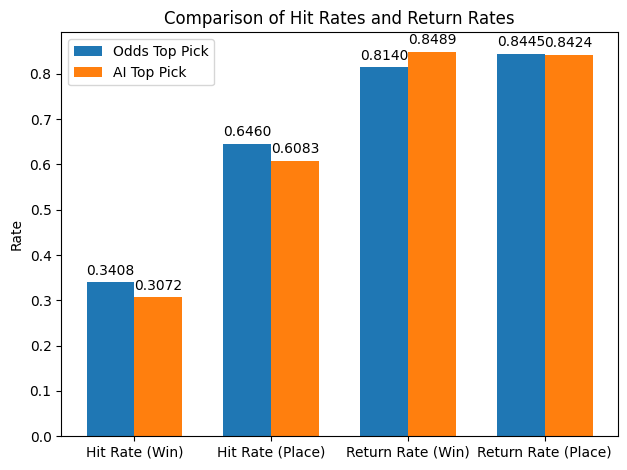

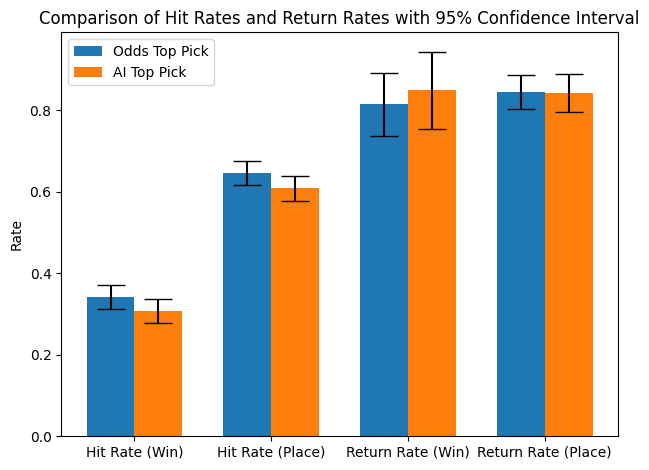

In [143]:
# 必要なライブラリをインポート
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

# 的中率と回収率を計算する関数
def calculate_rates(df):
    tansho_odds_column = '単勝'
    fukusho_odds_column = '複勝'
    actual_rank_column = '着順'
    
    total_bets = len(df)
    hits = len(df[df[actual_rank_column] == 1])
    places = len(df[df[actual_rank_column] <= 3])
    hit_rate = hits / total_bets
    place_rate = places / total_bets
    win_return_rate = df[df[actual_rank_column] == 1][tansho_odds_column].sum() / total_bets
    place_return_rate = df[df[actual_rank_column] <= 3][fukusho_odds_column].sum() / total_bets
    
    return pd.Series([hit_rate, place_rate, win_return_rate, place_return_rate], 
                     index=['hit_rate', 'place_rate', 'win_return_rate', 'place_return_rate'])


#上で保存した評価用データセットにAI予測確率を結合したファイルの読み込み
results = pd.read_pickle('x_test.pickle')

# 予測確率をデータフレームに追加
results_df = results

# オッズとAIによる最良の馬を特定
odds_best_horses = results_df.sort_values(['race_id', '単勝']).drop_duplicates(subset='race_id')
ai_best_horses = results_df.sort_values(['race_id', '予想確率'], ascending=[True, False]).drop_duplicates(subset='race_id')

# RaceIDごとに的中率と回収率を計算
odds_metrics = odds_best_horses.groupby('race_id').apply(calculate_rates)
ai_metrics = ai_best_horses.groupby('race_id').apply(calculate_rates)

# 平均的中率と回収率を計算
avg_odds_metrics = odds_metrics.mean()
avg_ai_metrics = ai_metrics.mean()

# グラフを作成する関数
def plot_comparison(labels, odds_rates, ai_rates):
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, odds_rates, width, label='Odds Top Pick')
    rects2 = ax.bar(x + width/2, ai_rates, width, label='AI Top Pick')

    # 数値をバーの上に追加
    for rect in rects1:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    for rect in rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.set_ylabel('Rate')
    ax.set_title('Comparison of Hit Rates and Return Rates')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()

    plt.show()

# プロット用データの準備
labels = ['Hit Rate (Win)', 'Hit Rate (Place)', 'Return Rate (Win)', 'Return Rate (Place)']
odds_rates = avg_odds_metrics.values
ai_rates = avg_ai_metrics.values

# グラフを作成
plot_comparison(labels, odds_rates, ai_rates)

# 信頼区間を計算する関数
from scipy import stats
import numpy as np

# 信頼区間を計算する関数
def calculate_confidence_interval(data, confidence=0.95):
    data = np.array(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    dof = len(data) - 1
    ci = std_err * stats.t.ppf((1 + confidence) / 2, dof)
    return mean, ci

# 信頼区間を計算
odds_hit_rates_ci = calculate_confidence_interval(odds_metrics['hit_rate'])
odds_place_rates_ci = calculate_confidence_interval(odds_metrics['place_rate'])
odds_win_return_rates_ci = calculate_confidence_interval(odds_metrics['win_return_rate'])
odds_place_return_rates_ci = calculate_confidence_interval(odds_metrics['place_return_rate'])

ai_hit_rates_ci = calculate_confidence_interval(ai_metrics['hit_rate'])
ai_place_rates_ci = calculate_confidence_interval(ai_metrics['place_rate'])
ai_win_return_rates_ci = calculate_confidence_interval(ai_metrics['win_return_rate'])
ai_place_return_rates_ci = calculate_confidence_interval(ai_metrics['place_return_rate'])

# プロット用データの準備
labels = ['Hit Rate (Win)', 'Hit Rate (Place)', 'Return Rate (Win)', 'Return Rate (Place)']
odds_rates = [odds_hit_rates_ci[0], odds_place_rates_ci[0], odds_win_return_rates_ci[0], odds_place_return_rates_ci[0]]
ai_rates = [ai_hit_rates_ci[0], ai_place_rates_ci[0], ai_win_return_rates_ci[0], ai_place_return_rates_ci[0]]
odds_ci = [odds_hit_rates_ci[1], odds_place_rates_ci[1], odds_win_return_rates_ci[1], odds_place_return_rates_ci[1]]
ai_ci = [ai_hit_rates_ci[1], ai_place_rates_ci[1], ai_win_return_rates_ci[1], ai_place_return_rates_ci[1]]

# グラフを作成
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, odds_rates, width, label='Odds Top Pick', yerr=odds_ci, capsize=10)
rects2 = ax.bar(x + width/2, ai_rates, width, label='AI Top Pick', yerr=ai_ci, capsize=10)

ax.set_ylabel('Rate')
ax.set_title('Comparison of Hit Rates and Return Rates with 95% Confidence Interval')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

In [112]:

#時系列に沿ってデータを分割
def split_data(df, test_size):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list]
    test = df.loc[test_id_list]
    return train, test,test_id_list
    
#results_addinfo.to_pickle('results.pickle')

#上で保存したpickleファイルの読み込み
results = pd.read_pickle('results.pickle')

#前処理
results_p = preprocessing(results)

results_p.drop(["馬名"], axis=1, inplace=True)
results_d = pd.get_dummies(results_p)

#着順を0or1にする
results_d["rank"] = results_d["着順"].map(lambda x: x if x < 4 else 4)
train, test,test_id_list = split_data(results_d, test_size=0.3)
X_train = train.drop(["人気","着順", "date", "rank"], axis=1)
y_train = train["rank"]
X_test = test.drop(["人気","着順", "date", "rank"], axis=1)
y_test = test["rank"]
y_train = y_train.map(lambda x: 1 if x < 4 else 0)
y_test = y_test.map(lambda x: 1 if x < 4 else 0)
#LightGBMによる予測モデル作成
import lightgbm as lgb

params = {
    "num_leaves": 4,
    "n_estimators": 80,
    #'min_data_in_leaf': 15,
    "class_weight": "balanced",
    "random_state": 100,
}

# lgb_clf = lgb.LGBMClassifier(**params)
# lgb_clf.fit(X_train.values, y_train.values)
# 以下修正分

# train, test = split_data(r.data_c)

# #説明変数と目的変数に分ける。dateはこの後不要なので省く。
# X_train = train.drop(['単勝','着順','rank', 'date'], axis=1)
# y_train = train['rank']
# #2021/3/12追加： テストデータの単勝オッズはシミュレーション時に使用するので残しておく
# X_test = test.drop(['単勝','着順','rank', 'date'], axis=1)
# y_test = test['rank']

# 終了

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
y_pred_train = lgb_clf.predict_proba(X_train)[:, 1]
y_pred = lgb_clf.predict_proba(X_test)[:, 1]

#ベンチマーク計算用のデータ
X_test_with_pred = test.copy()
X_test_with_pred = X_test_with_pred.drop(["date","枠番","斤量"], axis=1)
X_test_with_pred['予想確率'] = y_pred
X_test_with_pred['race_id'] = X_test_with_pred.index
fukusho = pd.read_pickle('fukusho.pickle')
fukusho['race_id'] = fukusho.index

# winとreturnを整形して一つのDataFrameにまとめる
reshaped_fukusho_list = []
for idx, row in fukusho.iterrows():
    for i in range(3):  # 0, 1, 2
        win = row[f'win_{i}']
        ret = row[f'return_{i}']
        reshaped_fukusho_list.append({'race_id': idx, '馬番': win, '複勝': ret / 100})

reshaped_fukusho_df = pd.DataFrame(reshaped_fukusho_list)

# x_testと整形したDataFrameを結合
X_test_with_pred = pd.merge(X_test_with_pred, reshaped_fukusho_df, on=['race_id', '馬番'], how='left').fillna(0)

print(X_test_with_pred['複勝'])

X_test_with_pred.to_pickle('x_test.pickle')

#ROC曲線の表示
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

#変数の重要度の表示
importances = pd.DataFrame(
    {"features": X_train.columns, "importance": lgb_clf.feature_importances_}
)
importances.sort_values("importance", ascending=False)[:20]

[LightGBM] [Info] Number of positive: 6880, number of negative: 24278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 194
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
0        1.7
1        2.0
2        3.4
3        0.0
4        0.0
        ... 
13248    0.0
13249    0.0
13250    0.0
13251    0.0
13252    0.0
Name: 複勝, Length: 13253, dtype: float64
0.8223642307275991
0.8124464400238843


,features,importance
3,単勝,142
1,馬番,17
0,枠番,11
4,年齢,11
5,体重,10
6,体重変化,7
168,騎手_藤田菜七,6
25,騎手_中村将之,5
28,騎手_丹内祐次,5
133,騎手_津村明秀,4


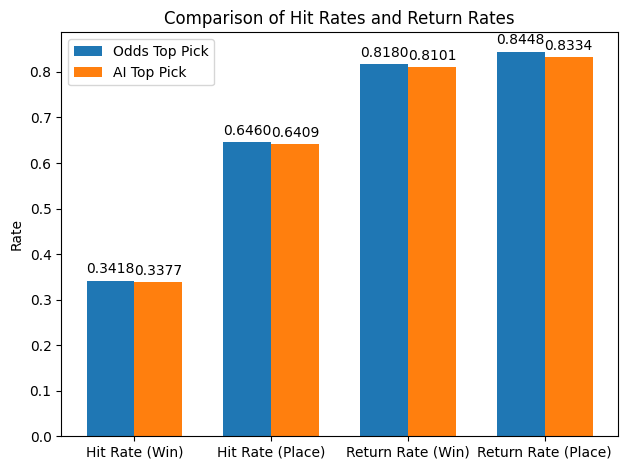

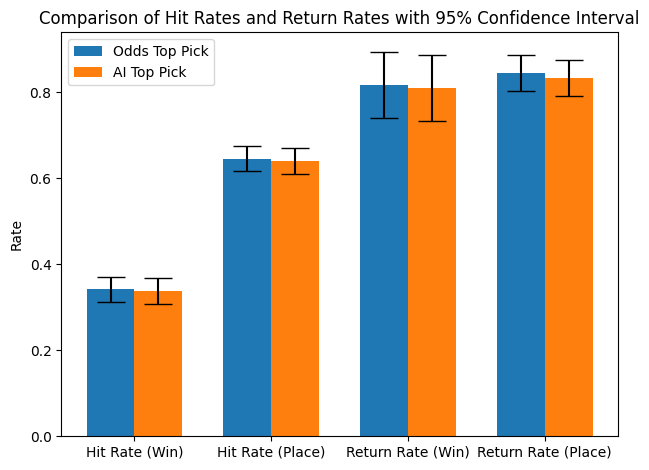

In [113]:
# 必要なライブラリをインポート
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

# 的中率と回収率を計算する関数
def calculate_rates(df):
    tansho_odds_column = '単勝'
    fukusho_odds_column = '複勝'
    actual_rank_column = '着順'
    
    total_bets = len(df)
    hits = len(df[df[actual_rank_column] == 1])
    places = len(df[df[actual_rank_column] <= 3])
    hit_rate = hits / total_bets
    place_rate = places / total_bets
    win_return_rate = df[df[actual_rank_column] == 1][tansho_odds_column].sum() / total_bets
    place_return_rate = df[df[actual_rank_column] <= 3][fukusho_odds_column].sum() / total_bets
    
    return pd.Series([hit_rate, place_rate, win_return_rate, place_return_rate], 
                     index=['hit_rate', 'place_rate', 'win_return_rate', 'place_return_rate'])


#上で保存した評価用データセットにAI予測確率を結合したファイルの読み込み
results = pd.read_pickle('x_test.pickle')

# 予測確率をデータフレームに追加
results_df = results

# オッズとAIによる最良の馬を特定
odds_best_horses = results_df.sort_values(['race_id', '単勝']).drop_duplicates(subset='race_id')
ai_best_horses = results_df.sort_values(['race_id', '予想確率'], ascending=[True, False]).drop_duplicates(subset='race_id')

# RaceIDごとに的中率と回収率を計算
odds_metrics = odds_best_horses.groupby('race_id').apply(calculate_rates)
ai_metrics = ai_best_horses.groupby('race_id').apply(calculate_rates)

# 平均的中率と回収率を計算
avg_odds_metrics = odds_metrics.mean()
avg_ai_metrics = ai_metrics.mean()

# グラフを作成する関数
def plot_comparison(labels, odds_rates, ai_rates):
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, odds_rates, width, label='Odds Top Pick')
    rects2 = ax.bar(x + width/2, ai_rates, width, label='AI Top Pick')

    # 数値をバーの上に追加
    for rect in rects1:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    for rect in rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.set_ylabel('Rate')
    ax.set_title('Comparison of Hit Rates and Return Rates')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()

    plt.show()

# プロット用データの準備
labels = ['Hit Rate (Win)', 'Hit Rate (Place)', 'Return Rate (Win)', 'Return Rate (Place)']
odds_rates = avg_odds_metrics.values
ai_rates = avg_ai_metrics.values

# グラフを作成
plot_comparison(labels, odds_rates, ai_rates)

# 信頼区間を計算する関数
from scipy import stats
import numpy as np

# 信頼区間を計算する関数
def calculate_confidence_interval(data, confidence=0.95):
    data = np.array(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    dof = len(data) - 1
    ci = std_err * stats.t.ppf((1 + confidence) / 2, dof)
    return mean, ci

# 信頼区間を計算
odds_hit_rates_ci = calculate_confidence_interval(odds_metrics['hit_rate'])
odds_place_rates_ci = calculate_confidence_interval(odds_metrics['place_rate'])
odds_win_return_rates_ci = calculate_confidence_interval(odds_metrics['win_return_rate'])
odds_place_return_rates_ci = calculate_confidence_interval(odds_metrics['place_return_rate'])

ai_hit_rates_ci = calculate_confidence_interval(ai_metrics['hit_rate'])
ai_place_rates_ci = calculate_confidence_interval(ai_metrics['place_rate'])
ai_win_return_rates_ci = calculate_confidence_interval(ai_metrics['win_return_rate'])
ai_place_return_rates_ci = calculate_confidence_interval(ai_metrics['place_return_rate'])

# プロット用データの準備
labels = ['Hit Rate (Win)', 'Hit Rate (Place)', 'Return Rate (Win)', 'Return Rate (Place)']
odds_rates = [odds_hit_rates_ci[0], odds_place_rates_ci[0], odds_win_return_rates_ci[0], odds_place_return_rates_ci[0]]
ai_rates = [ai_hit_rates_ci[0], ai_place_rates_ci[0], ai_win_return_rates_ci[0], ai_place_return_rates_ci[0]]
odds_ci = [odds_hit_rates_ci[1], odds_place_rates_ci[1], odds_win_return_rates_ci[1], odds_place_return_rates_ci[1]]
ai_ci = [ai_hit_rates_ci[1], ai_place_rates_ci[1], ai_win_return_rates_ci[1], ai_place_return_rates_ci[1]]

# グラフを作成
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, odds_rates, width, label='Odds Top Pick', yerr=odds_ci, capsize=10)
rects2 = ax.bar(x + width/2, ai_rates, width, label='AI Top Pick', yerr=ai_ci, capsize=10)

ax.set_ylabel('Rate')
ax.set_title('Comparison of Hit Rates and Return Rates with 95% Confidence Interval')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()